In [1]:

import sys  
sys_path="d:\\software\\python3\\lib\\site-packages"
sys.path.append(sys_path)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import linear_model
import os
#%matplotlib inline 这个是在jupyternotebook里才可以用的
pd.set_option("display.max_columns", 6)
#style.use("fivethirtyeight")

chang_path="D:/中南财经政法大学/课程资料 class info/金融计量/python file/python-causality-handbook-master/causal-inference-for-the-brave-and-true"
os.chdir(chang_path)
#%matplotlib inline


In [2]:

cigar = (pd.read_csv("data/smoking.csv").drop(columns=["lnincome","beer", "age15to24"]))

print(cigar.query("california ==  True").head()) #query取用命令


    state  year     cigsale   retprice  california  after_treatment
62      3  1970  123.000000  38.799999        True            False
63      3  1971  121.000000  39.700001        True            False
64      3  1972  123.500000  39.900002        True            False
65      3  1973  124.400002  39.900002        True            False
66      3  1974  126.699997  41.900002        True            False


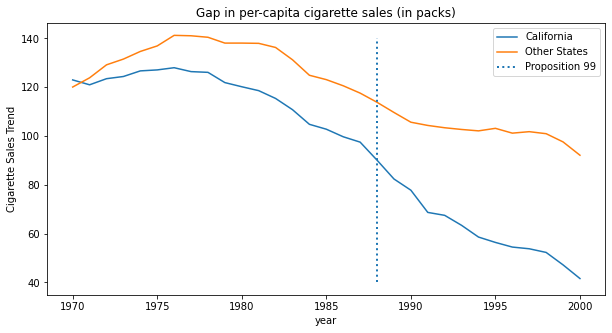

In [3]:

#%matplotlib inline

ax = plt.subplot(1, 1, 1)

(cigar.assign(california = np.where(cigar["california"], "California", "Other States")).groupby(["year", "california"])["cigsale"]
 .mean()
 .reset_index()
 .pivot("year", "california", "cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend()

In [4]:

features = ["cigsale", "retprice"]
#pivot函数用来重塑数据，官方定义如下所示 pivot(index=None, columns=None, values=None)，设定新的索引
inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

print(type(inverted),inverted.shape,inverted.head())

<class 'pandas.core.frame.DataFrame'> (38, 39) state                 1           2           3   ...          37          38  \
        year                                      ...                           
cigsale 1970   89.800003  100.300003  123.000000  ...  114.500000  106.400002   
        1971   95.400002  104.099998  121.000000  ...  111.500000  105.400002   
        1972  101.099998  103.900002  123.500000  ...  117.500000  108.800003   
        1973  102.900002  108.000000  124.400002  ...  116.599998  109.500000   
        1974  108.199997  109.699997  126.699997  ...  119.900002  111.800003   

state                 39  
        year              
cigsale 1970  132.199997  
        1971  131.699997  
        1972  140.000000  
        1973  141.199997  
        1974  145.800003  

[5 rows x 39 columns]


In [5]:
#Now, we can define our Y variable as the state of California and the X as the other states. #state等于3的时候就是cal
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states
print(X)
#%%
from sklearn.linear_model import Lasso
#help(Lasso)
weights_lr = Lasso(fit_intercept=False).fit(X, y).coef_
print(weights_lr.round(3))
#weights_lr.round(3) #round(3),保留小数点后三位

[[ 89.80000305 100.30000305 124.80000305 ... 114.5        106.40000153
  132.19999695]
 [ 95.40000153 104.09999847 125.5        ... 111.5        105.40000153
  131.69999695]
 [101.09999847 103.90000153 134.30000305 ... 117.5        108.80000305
  140.        ]
 ...
 [103.         103.59999847  95.09999847 ... 104.09999847 110.80000305
   97.80000305]
 [110.         113.         108.59999847 ... 112.80000305 116.30000305
  102.69999695]
 [114.40000153 119.90000153 116.         ... 122.19999695 128.6000061
  112.90000153]]
[ 0.566 -0.     0.317  0.158  0.    -0.181  0.035  0.022  0.056  0.
 -0.075 -0.003 -0.126 -0.005  0.078 -0.183 -0.006  0.415  0.     0.166
  0.012  0.025 -0.032 -0.214 -0.058 -0.015 -0.    -0.034 -0.103 -0.
 -0.105  0.088  0.     0.    -0.016  0.132  0.     0.049]


D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.160e+02, tolerance: 3.557e+01
  model = cd_fast.enet_coordinate_descent(


In [6]:
calif_synth_lr = (cigar.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))
print(calif_synth_lr)


[121.84643584 121.65104722 125.52852431 124.07570198 125.42476248
 125.85312836 126.74305938 127.24123474 126.23281383 122.68718605
 120.23991355 118.18294791 115.04636999 110.47702436 104.55006315
 103.09368733 101.12849967  97.23347841  91.77126269  87.88162613
  90.59884576  82.77184554  86.28568603  84.9519961   85.29770771
  83.51235994  79.97221492  80.82252528  82.45732646  80.33763458
  73.01913122]


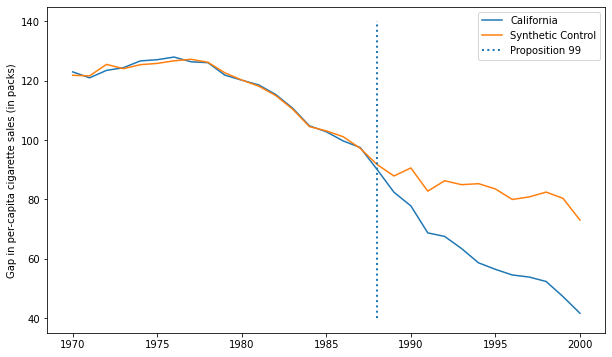

In [7]:

plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();


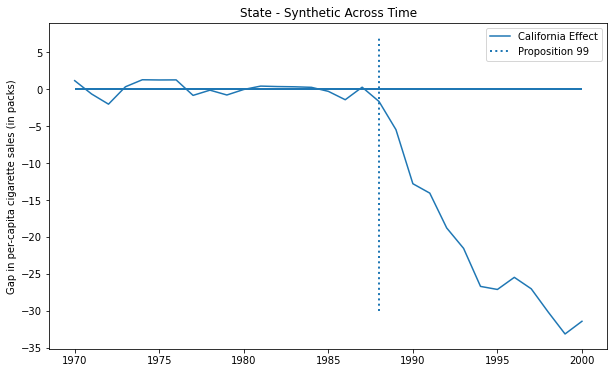

In [9]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth_lr,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

In [10]:
def synthetic_control(state, pool, data) -> np.array:
    features = ["cigsale", "retprice"]
    inverted = (data.query("~after_treatment") #~是对after_treatment 取反值，true就取为false
                .pivot(index='state', columns="year")[features]
                .T)
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool
    weights = Lasso(fit_intercept=False).fit(X, y).coef_.round(8)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))
    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

In [11]:
print(synthetic_control(1,1, cigar)) #这就是对state1进行合成控制法的命令


    state  year     cigsale  after_treatment   synthetic
0       1  1970   89.800003            False   92.488668
1       1  1971   95.400002            False   95.469261
2       1  1972  101.099998            False   99.597049
3       1  1973  102.900002            False  104.186882
4       1  1974  108.199997            False  107.607981
5       1  1975  111.699997            False  112.563829
6       1  1976  116.199997            False  114.774845
7       1  1977  117.099998            False  117.722953
8       1  1978  123.000000            False  121.437572
9       1  1979  121.400002            False  119.724292
10      1  1980  123.199997            False  123.744052
11      1  1981  119.599998            False  120.447573
12      1  1982  119.099998            False  118.586617
13      1  1983  116.300003            False  118.474953
14      1  1984  113.000000            False  112.906595
15      1  1985  114.500000            False  115.504290
16      1  1986  116.300003    

D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.342e+01, tolerance: 3.384e+01
  model = cd_fast.enet_coordinate_descent(


In [12]:
control_pool = cigar["state"].unique()
print(control_pool)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [13]:
synthetic_states = [synthetic_control(state, control_pool, cigar) for state in control_pool]
print(synthetic_states[1])

D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.342e+01, tolerance: 3.384e+01
  model = cd_fast.enet_coordinate_descent(
D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.233e+01, tolerance: 3.726e+01
  model = cd_fast.enet_coordinate_descent(
D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.160e+02, tolerance: 3.557e+01

    state  year     cigsale  after_treatment   synthetic
31      2  1970  100.300003            False   99.828518
32      2  1971  104.099998            False  104.152684
33      2  1972  103.900002            False  105.159418
34      2  1973  108.000000            False  107.867820
35      2  1974  109.699997            False  111.452546
36      2  1975  114.800003            False  114.064059
37      2  1976  119.099998            False  119.476385
38      2  1977  122.599998            False  121.402692
39      2  1978  127.300003            False  127.266028
40      2  1979  126.500000            False  127.561519
41      2  1980  131.800003            False  130.498171
42      2  1981  128.699997            False  129.036879
43      2  1982  127.400002            False  129.300493
44      2  1983  128.000000            False  126.337753
45      2  1984  123.099998            False  123.948081
46      2  1985  125.800003            False  124.471377
47      2  1986  126.000000    

D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.080e+02, tolerance: 3.697e+01
  model = cd_fast.enet_coordinate_descent(
D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+02, tolerance: 1.916e+01
  model = cd_fast.enet_coordinate_descent(
D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e+02, tolerance: 5.174e+01

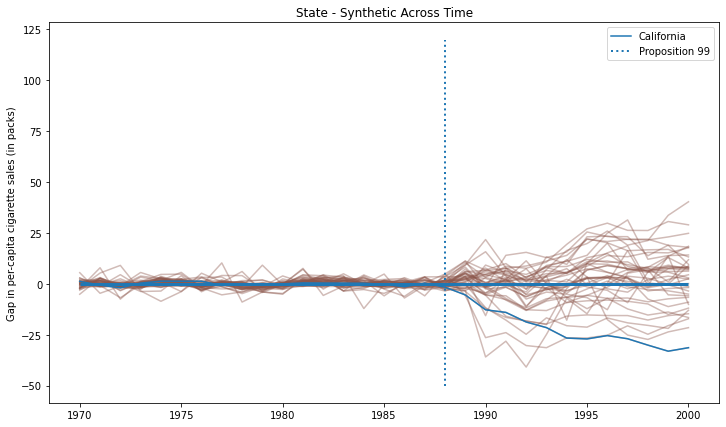

In [14]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth_lr,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();
#%%

In [14]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

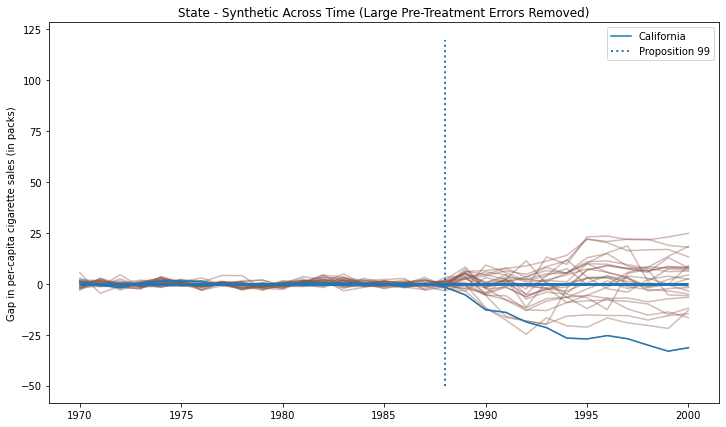

In [15]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    
    # remove units with mean error above 5.
    if pre_treatment_error(state) < 5:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth_lr,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

In [16]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth_lr[-1] 

print("California Treatment Effect for the Year 2000:", calif_effect)
print(np.array(effects))

California Treatment Effect for the Year 2000: -31.41913274831375
[  8.00390326  -5.08609582 -31.4191325    2.89915069  -6.67270179
  40.28896161 -16.60501222   2.24307356 -11.9728605   28.95369938
  17.67446064   0.09191459  14.14720373   8.9407977   -9.05188584
   7.36361488   7.35631561   8.26629922  17.91307307   7.78282827
   8.23965478 -10.14395454  -1.38889784  11.81540311   2.46943897
  -1.84985393  18.41227207   4.4139876  -17.2009126   -5.90082447
  13.1952029   -3.57435217 -13.04705819   6.84568025 -21.57109054
 -14.73968494  24.78820584   6.20725119   9.5374455 ]


In [17]:
print(np.mean(np.array(effects) < calif_effect).raiseound(3))


AttributeError: 'numpy.float64' object has no attribute 'raiseound'

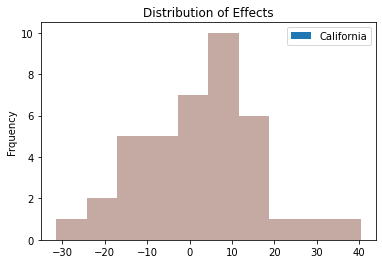

In [18]:
_, bins, _ = plt.hist(effects, bins=10, color="C5", alpha=0.5);
plt.hist([calif_effect], bins=bins, color="C0", label="California")
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend();